## EDA

In [1]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
from torchvision import datasets, models, transforms

In [2]:
dataset_path = '/media/alex/80CA308ECA308288/alex_dataset/scene_classification'

In [3]:
dataset_dir = pathlib.Path(dataset_path)

labels_path = list(dataset_dir.glob('./*.csv'))[0]

train_data_path = os.path.join(dataset_path, 'train')
test_data_path = os.path.join(dataset_path, 'train')

images_labels = pd.read_csv(labels_path, sep=',', header=0)

train_labels = images_labels['label']

labels_count = train_labels.value_counts(sort=False)

print(labels_count)

sea          2201
forest       2210
street       2322
buildings    2109
glacier      2351
mountain     2434
Name: label, dtype: int64


In [4]:
category = sorted(set(train_labels.values.tolist()))

class_index = {c:i for i, c in enumerate(category)}
index_class = {i:c for i, c in enumerate(category)}

print(class_index)
print(index_class)


{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


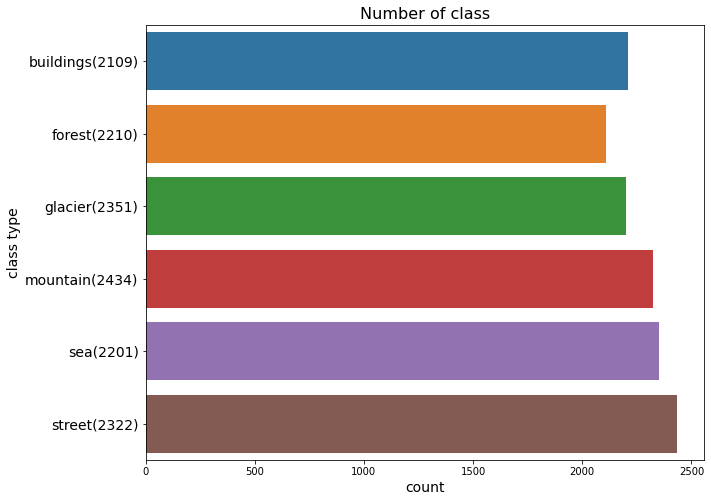

Done


In [5]:
# get yticks label
yticks_label = ['{0}({1})'.format(c, labels_count[c]) for c in class_index.keys()]

plt.figure(figsize=(10, 8))
sns.countplot(y=train_labels, hue_order=class_index.keys())
# sns.countplot(y=train_labels, hue_order=class_index.keys())

# sns.barplot(x=class_count.index, y=class_count.values)
plt.title('Number of class', fontsize=16)
plt.xlabel('count', fontsize=14)
plt.ylabel('class type', fontsize=14)
plt.yticks(range(len(yticks_label)), yticks_label, fontsize=14)
plt.show()


print('Done')

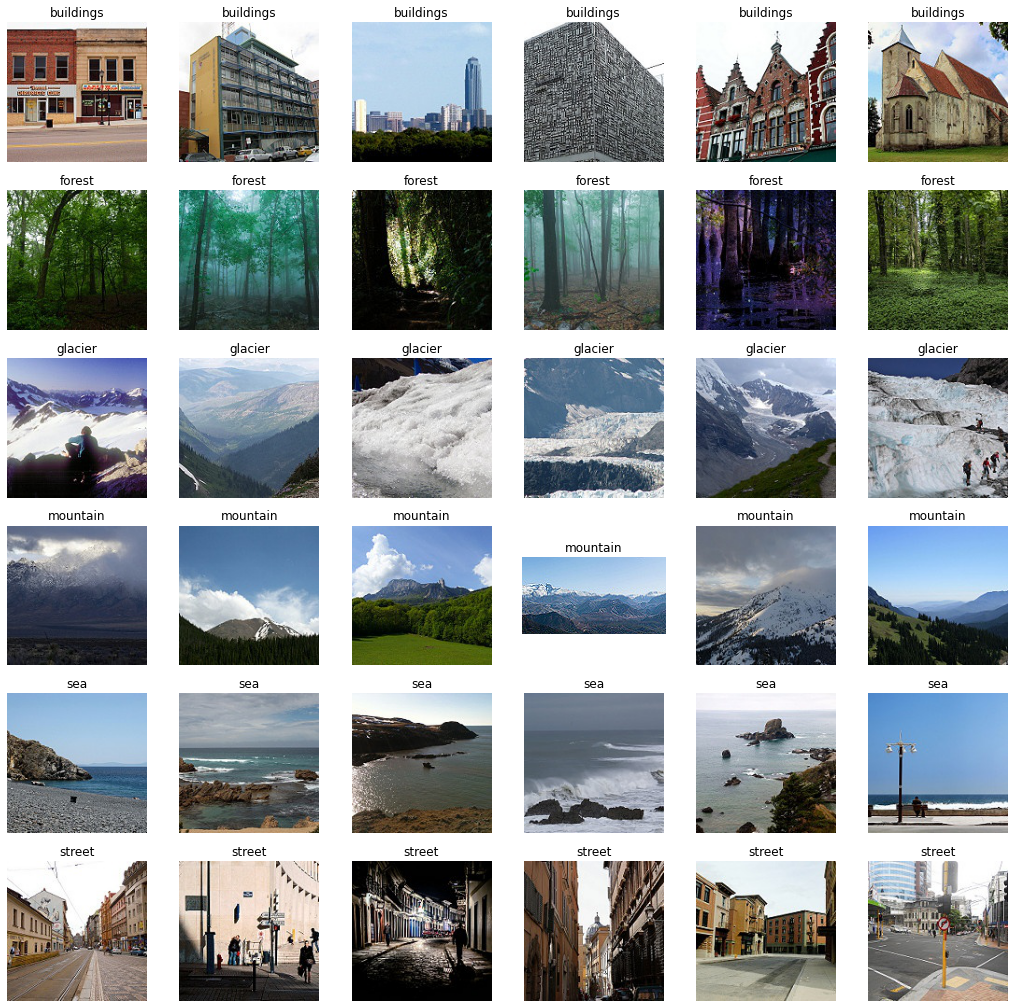

In [6]:
# show sample

# images_labels = images_labels.sample(frac=1.).reset_index(drop=True)  # shuffle dataframe
sub_buildings = images_labels[images_labels['label'] == index_class[0]]['filename'].iloc[:6].to_list()
sub_forest = images_labels[images_labels['label'] == index_class[1]]['filename'].iloc[:6].to_list()
sub_glacier = images_labels[images_labels['label'] == index_class[2]]['filename'].iloc[:6].to_list()
sub_mountain = images_labels[images_labels['label'] == index_class[3]]['filename'].iloc[:6].to_list()
sub_sea = images_labels[images_labels['label'] == index_class[4]]['filename'].iloc[:6].to_list()
sub_street = images_labels[images_labels['label'] == index_class[5]]['filename'].iloc[:6].to_list()

sample_images = sub_buildings + sub_forest + sub_glacier+ sub_mountain + sub_sea + sub_street
sample_labels = [0] * 6 + [1] *6 + [2] * 6 + [3] * 6 + [4] * 6 + [5] * 6


fig, ax = plt.subplots(6, 6, figsize=(18, 18))
for n, (img_name, img_label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(6, 6, n+1)
    plt.imshow(np.array(Image.open(os.path.join(train_data_path, img_name))))
    plt.title(index_class[img_label])
    plt.axis('off')
plt.show()

## Dataset Loader

In [7]:
# custom dataset
class SceneDataset(data.Dataset):

    def __init__(self, data, target, transforms=None):
        super(SceneDataset, self).__init__()

        self.data = data
        self.target = target
        self.transforms = transforms

    def __len__(self):

        return len(self.data)


    def __getitem__(self, index):

        img_path, target = self.data[index], self.target[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = self.pil_loader(img_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

In [8]:
class DataProvider(object):

    def __init__(self, images, labels, split_ratio):

        self.train_images = images[: int(len(images) * split_ratio)]
        self.train_labels = labels[: int(len(labels) * split_ratio)]
        self.val_images = images[int(len(images) * split_ratio):]
        self.val_labels = labels[int(len(labels) * split_ratio):]

        self.data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

    def data_loader(self, batch_size, phase='train', shuffle=False, num_worker=4):
        assert phase in ['train', 'val']
        if phase == 'train':
            dataset = SceneDataset(self.train_images, self.train_labels, self.data_transforms[phase])
            loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_worker)
        else:
            dataset = SceneDataset(self.val_images, self.val_labels, self.data_transforms[phase])
            loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_worker)

        return loader

In [9]:
train_val_images = [os.path.join(train_data_path, img) for img in images_labels['filename'].tolist()]
train_val_labels =  [class_index[c] for c in images_labels['label'].tolist()]

data_loader = DataProvider(train_val_images, train_val_labels, split_ratio=0.9)

train_loader = data_loader.data_loader(batch_size=256, phase='train', shuffle=True, num_worker=4)
val_loader = data_loader.data_loader(batch_size=256, phase='val', shuffle=False, num_worker=4)

In [10]:
def plt_imshow(image, title=None):
    
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # clip to (0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

In [11]:
def plot_image_class(images, labels):

    labels = [index_class[index] for index in labels.numpy()]
    fig, axs = plt.subplots(6, 6, figsize=(18, 18))
    for n, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(6, 6, n+1)
        plt_imshow(img, label)
        plt.axis('off')
    plt.show()

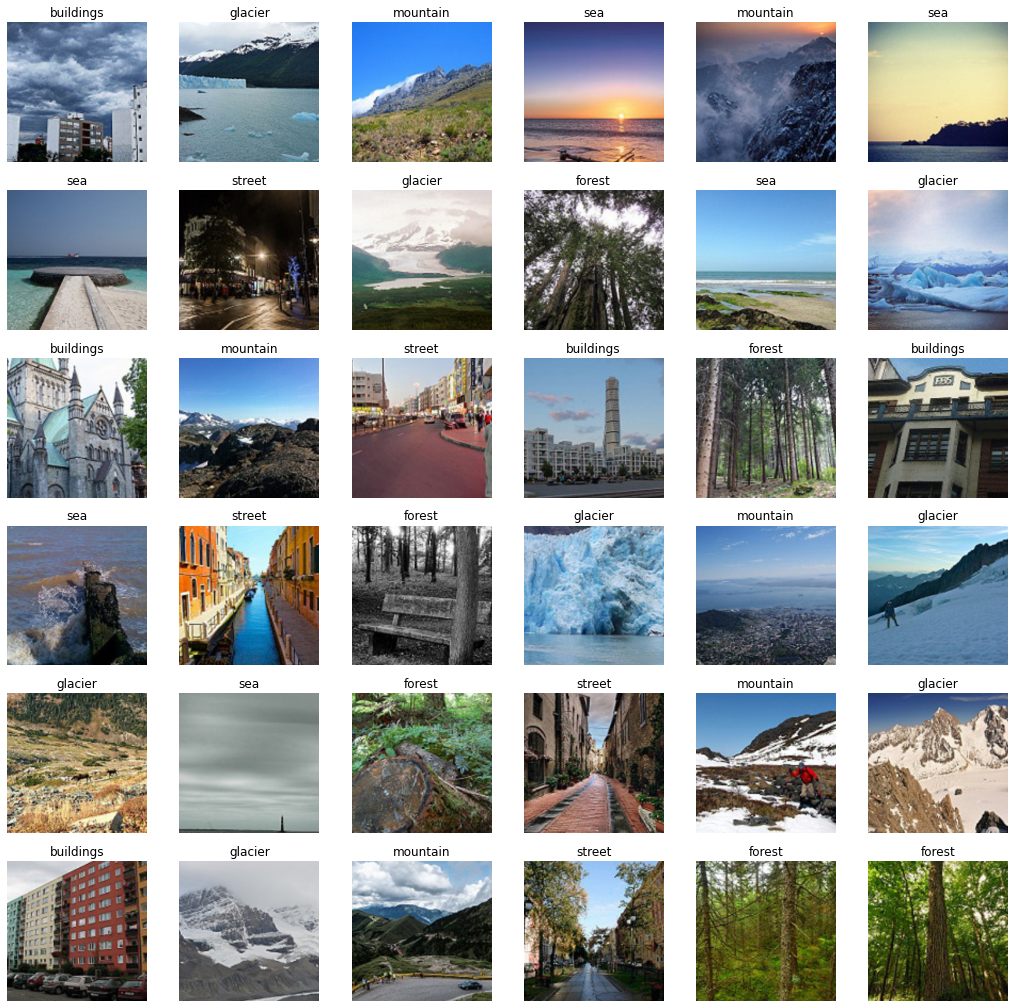

In [12]:
image_tensor, labels_tensor = next(iter(val_loader))

plot_image_class(image_tensor[:36], labels_tensor[:36])